# SNOMED-CT codes for Prior-Authorization Prediction

Kolton Hauck

BMI6114
<hr>

This notebook outlines the primary implementation of the final project for BMI6614. The other notebook `preprocessing.ipynb` is required for this notebook to run.

Prior-Authorization is an important procedure in healthcare. Automating the process would be very beneficial. This project utilizes the synthea dataset, specifically the descriptions of SNOMED-CT codes, as features. Since synthea doesn't contain explicit prior-authorization data, the project was simplified to a prediction task on whether or not the next procedure a patient will receive is `chest x-ray` or something else. This acts as a precursor or proof of concept on whether utilizing SNOMED-CT code descriptions would be helpful in PA.

The implementation in this notebook is as follows:
- import the data
- define the dataloaders
- train / test the deep learning models
    - fully connected feed forward
        - 3 hidden layers (128, 128, 1)
        - loss fn: `BCEWithLogitsLoss`
        - activation fn: `ReLU`
        - optimizer: `Adam` with `lr`=0.001
        - `batch_size`=30
        - also tested were different aggregation techniques for the features (because each patient had a varying number of encounters / SNOMED-CT codes)
            - mean agg. the embeddings
            - get the mean of the logits generated for each embedding
            - get the max of the logits generated for each embedding
    - model with attention weights with 2 fully connected layers
        - `nn.MultiAttentionHead`: 6 attention heads
        - 2 fully connected layers (128, 1)
        - loss fn: `BCEWithLogitsLoss`
        - activation fn: `ReLU`
        - optimizer: `Adam` with `lr`=0.001
        - `batch_size`=30
- train / test the traditional machine learning models
    - logistic regression
        - averaged array of embeddings as input feats.
        - `Optuna` used for hyperparameter tuning
            - 100 studies done
    - random forest
        - averaged array of embeddings as input feats.
        - `Optuna` used for hyperparameter tuning
            - 100 studies done

# Setup

- imports
- import data used


## Imports

In [1]:
import pandas as pd
import json
import os

from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger
import lightning as L

from torch.nn import functional as F

import optuna

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score

from utils import *

/home/kolton.hauck/miniconda3/envs/python310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Setup

In [44]:
# read in data
with open("data/all.json","r") as j_file:
    data = json.load(j_file)

# define train, val, test batch sizes
batch_sizes = (30, 30, 20)

# get dataloaders
train_dl, val_dl, test_dl, _ = load_data(data, batch_sizes=batch_sizes)


        train: 40409
        val: 8659
        test: 8660
        


# DL Models Implementation

## Fully Connected Feed Forward

In [45]:
# init model
model = FC(batch_sizes=batch_sizes, agg_type="logits_max")

# init logger
logger = CSVLogger("logs", name="fc")

# init trainer
trainer = L.Trainer(
    max_epochs=10,
    accelerator="gpu",
    strategy="ddp_notebook",
    callbacks=[
        ModelCheckpoint(
            monitor="val_loss", mode="min", save_last=False, save_top_k=1,
            dirpath="checkpoints/", filename="fc-logitsmaxv1-{epoch:02d}-{val_mse:.2f}-"
        ),
        EarlyStopping(monitor="val_loss", patience=2, mode="min")
    ],
    logger=logger,
    devices=2,
    log_every_n_steps=5
)

# train model
trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=val_dl)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 2 processes
----------------------------------------------------------------------------------------------------

/home/kolton.hauck/miniconda3/envs/python310/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kolton.hauck/BMI6114_FinalProject/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name      | Type              | Params
------------------------------------------------
0 | fc1       | Linear            | 98.4 K
1 | fc2       | Linear            | 16.5 K
2 | fc3       | Linear            | 129   
3 | loss_fn   | BCEWithLogitsLoss

Epoch 9: 100%|██████████| 166/166 [00:35<00:00,  4.65it/s, v_num=6, train_loss_step=9.6e-6, train_acc_step=1.000, val_loss_step=1.47e-5, val_acc_step=1.000, val_loss_epoch=1.55e-5, val_acc_epoch=1.000, train_loss_epoch=1.18e-5, train_acc_epoch=1.000]     

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 166/166 [00:35<00:00,  4.65it/s, v_num=6, train_loss_step=9.6e-6, train_acc_step=1.000, val_loss_step=1.47e-5, val_acc_step=1.000, val_loss_epoch=1.55e-5, val_acc_epoch=1.000, train_loss_epoch=1.18e-5, train_acc_epoch=1.000]


array([[<Axes: >, <Axes: >]], dtype=object)

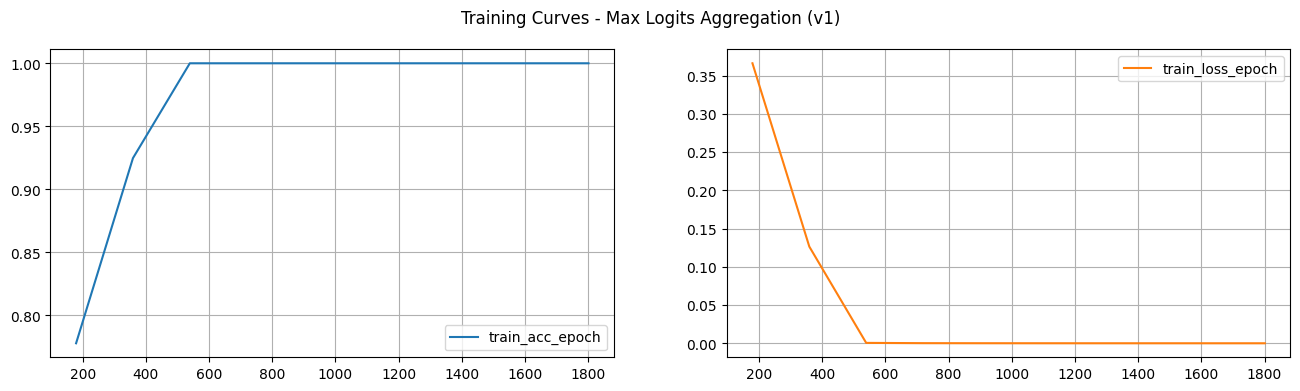

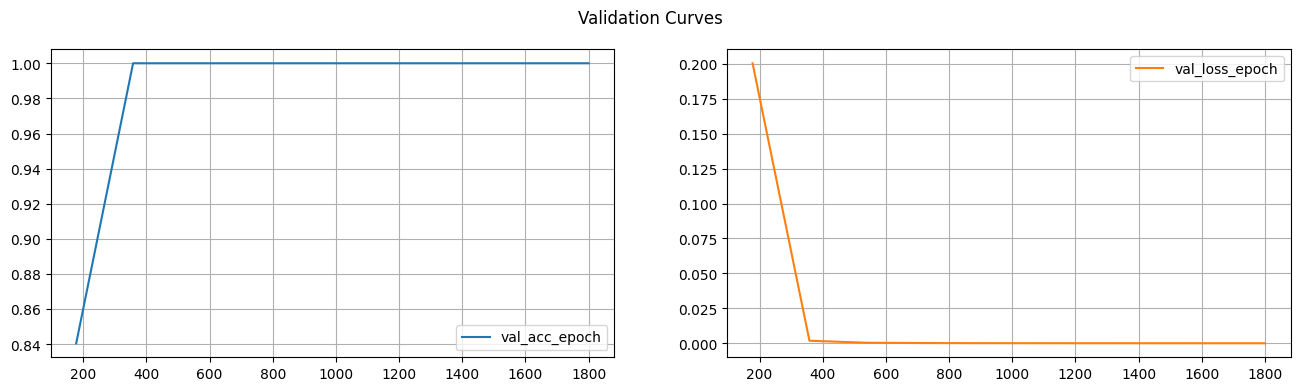

In [46]:
### version 0: mean logits agg
### version 2: mean seq agg
### version 4: max logits agg
### version 6: max logits agg v1

num = len(os.listdir("./logs/fc")) - 1
logs_to_read = f"./logs/fc/version_{num}/metrics.csv"

hist = pd.read_csv(logs_to_read)
hist[['train_acc_epoch', 'train_loss_epoch']].dropna().plot(subplots=True, layout=(1,2), figsize=(16,4),
                                         grid=True, title="Training Curves - Max Logits Aggregation (v1)")
hist[['val_acc_epoch', 'val_loss_epoch']].dropna().plot(subplots=True, layout=(1,2), figsize=(16,4),
                                         grid=True, title="Validation Curves")

In [47]:
# test model
trainer.test(model, dataloaders=test_dl)

Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 2 processes
----------------------------------------------------------------------------------------------------

LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
/home/kolton.hauck/miniconda3/envs/python310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:232: Using `DistributedSampler` with the dataloaders. During `trainer.test()`, it is recommended to use `Trainer(devices=1, num_nodes=1)` to ensure each sample/batch gets evaluated exactly once. Otherwise, multi-device settings use `DistributedSampler` that replicates some samples to make sure all devices have same batch size in case of uneven input

Testing DataLoader 0: 100%|██████████| 217/217 [00:16<00:00, 13.47it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_acc_epoch                 1.0
     test_loss_epoch      1.5370880646514706e-05
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss_epoch': 1.5370880646514706e-05, 'test_acc_epoch': 1.0}]

## Model with Attention weights

In [40]:
# init model
model = AttentionModelV2(batch_size=batch_sizes)

# init logger
logger = CSVLogger("logs", name="attention")

# init trainer
trainer = L.Trainer(
    max_epochs=10,
    accelerator="gpu",
    strategy="ddp_notebook",
    callbacks=[
        ModelCheckpoint(
            monitor="val_loss", mode="min", save_last=False, save_top_k=1,
            dirpath="checkpoints/", filename="attention-{epoch:02d}-{val_mse:.2f}-"
        ),
        EarlyStopping(monitor="val_loss", patience=3, mode="min")
    ],
    logger=logger,
    devices=2,
    log_every_n_steps=5
)

# train model
trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=val_dl)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 2 processes
----------------------------------------------------------------------------------------------------

/home/kolton.hauck/miniconda3/envs/python310/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kolton.hauck/BMI6114_FinalProject/checkpoints exists and is not empty.
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name            | Type               | Params
-------------------------------------------------------
0 | attention_layer | MultiheadAttention | 2.4 M 
1 | fc1             | Linear             | 98.4 K
2 | fc2             | Linear             | 129  

Epoch 9: 100%|██████████| 367/367 [01:13<00:00,  4.99it/s, v_num=2, train_loss_step=0.000, train_acc_step=1.000, val_loss_step=0.000, val_acc_step=1.000, val_loss_epoch=1.78e-7, val_acc_epoch=1.000, train_loss_epoch=3.32e-7, train_acc_epoch=1.000]    

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 367/367 [01:13<00:00,  4.98it/s, v_num=2, train_loss_step=0.000, train_acc_step=1.000, val_loss_step=0.000, val_acc_step=1.000, val_loss_epoch=1.78e-7, val_acc_epoch=1.000, train_loss_epoch=3.32e-7, train_acc_epoch=1.000]


array([[<Axes: >, <Axes: >]], dtype=object)

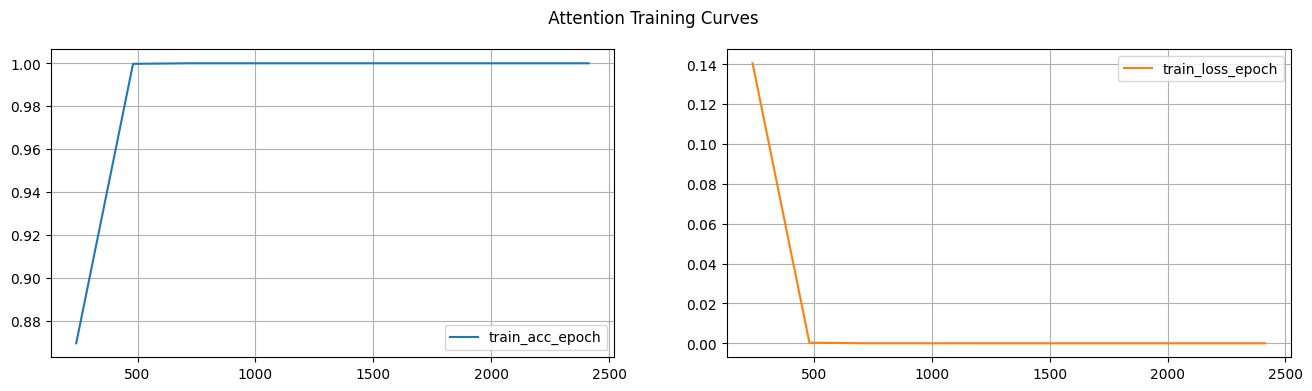

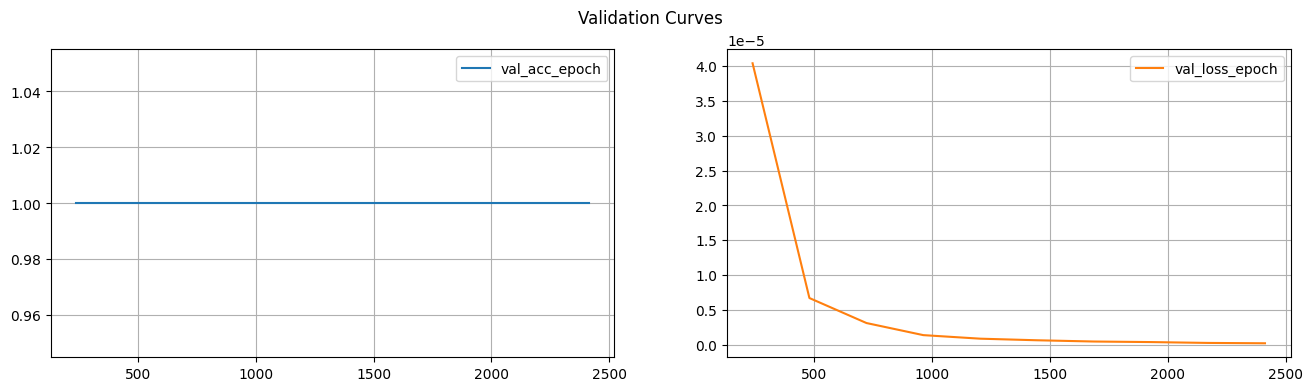

In [42]:
# version 0: attention with accuracy score
# version 2: attention with F1 score

num = len(os.listdir("./logs/attention")) - 1
logs_to_read = f"./logs/attention/version_{num}/metrics.csv"

hist = pd.read_csv(logs_to_read)
hist[['train_acc_epoch', 'train_loss_epoch']].dropna().plot(subplots=True, layout=(1,2), figsize=(16,4),
                                         grid=True, title=" Attention Training Curves")
hist[['val_acc_epoch', 'val_loss_epoch']].dropna().plot(subplots=True, layout=(1,2), figsize=(16,4),
                                         grid=True, title="Validation Curves")

In [43]:
# test model
trainer.test(model, dataloaders=test_dl)

Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 2 processes
----------------------------------------------------------------------------------------------------

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
/home/kolton.hauck/miniconda3/envs/python310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:232: Using `DistributedSampler` with the dataloaders. During `trainer.test()`, it is recommended to use `Trainer(devices=1, num_nodes=1)` to ensure each sample/batch gets evaluated exactly once. Otherwise, multi-device settings use `DistributedSampler` that replicates some samples to make sure all devices have same batch size in case of uneven input

Testing DataLoader 0: 100%|██████████| 249/249 [00:18<00:00, 13.28it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_acc_epoch                 1.0
     test_loss_epoch       3.216990194232494e-07
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss_epoch': 3.216990194232494e-07, 'test_acc_epoch': 1.0}]

# ML Models Implementation

## Random Forest

In [27]:
def rf_objective(trial):
    # define search space
    n_estimators = trial.suggest_int('n_estimators', 100, 200)
    max_depth = trial.suggest_int('max_depth', 10, 50, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
        
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                 min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                 max_features=max_features, random_state=42)
    
    # train model
    clf.fit(X_train, y_train)
    
    # eval model
    y_pred = clf.predict(X_val)
    accuracy = f1_score(y_val, y_pred)
    
    return accuracy  # Return the accuracy as the objective to maximize

# Create a study object
study = optuna.create_study(direction='maximize')
X_train, y_train, X_val, y_val, X_test, y_test, _ = load_data(data, model_type="ml-optuna")

# Execute an optimization
study.optimize(rf_objective, n_trials=10)  # Specify the number of trials

# show best params
best_params = study.best_params
print("Best parameters:", best_params)
print("Best value (accuracy):", study.best_value)

# train with best params
final_model = RandomForestClassifier(**best_params)
final_model.fit(X_train, y_train)  # Assuming train_X and train_y are already loaded and prepared

# eval best model on test set
final_predictions = final_model.predict(X_test)
final_accuracy = f1_score(y_test, final_predictions)
print(f"Final test accuracy: {final_accuracy:.2f}")


[I 2024-04-18 20:32:08,925] A new study created in memory with name: no-name-26cd7041-29d2-4d41-8a39-865a85957b4a



        train: 46431
        val: 9949
        test: 9951
        


[I 2024-04-18 20:36:22,960] Trial 0 finished with value: 0.8579615227179697 and parameters: {'n_estimators': 199, 'max_depth': 40, 'min_samples_split': 11, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8579615227179697.
[I 2024-04-18 20:37:55,567] Trial 1 finished with value: 0.8615384615384616 and parameters: {'n_estimators': 180, 'max_depth': 50, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.8615384615384616.
[I 2024-04-18 20:38:18,252] Trial 2 finished with value: 0.8513761467889909 and parameters: {'n_estimators': 134, 'max_depth': 28, 'min_samples_split': 13, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 1 with value: 0.8615384615384616.
[I 2024-04-18 21:10:27,806] Trial 3 finished with value: 0.8587044534412955 and parameters: {'n_estimators': 153, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 1 with value: 0.86153846153846

Best parameters: {'n_estimators': 133, 'max_depth': 40, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt'}
Best value (accuracy): 0.8681025641025641
Final test accuracy: 0.87


In [28]:
confusion_matrix(y_test, final_predictions)

array([[7196,  397],
       [ 249, 2109]])

## Logistic Regression

In [29]:
def objective(trial):
    # define search space
    C = trial.suggest_float('C', 1e-2, 1e1, log=True)
    solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga'])
    penalty = 'l2'  # default penalty

    if solver in ['liblinear', 'saga']:
        penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    
    clf = LogisticRegression(C=C, solver=solver, penalty=penalty, random_state=42, max_iter=100)
    
    # train model
    clf.fit(X_train, y_train)
    
    # eval model
    y_pred = clf.predict(X_val)
    accuracy = f1_score(y_val, y_pred)
    
    return accuracy

# define optuna study
study = optuna.create_study(direction='maximize')
X_train, y_train, X_val, y_val, X_test, y_test, _ = load_data(data, model_type="ml-optuna")

# get best params
study.optimize(objective, n_trials=10)  # Specify the number of trials

# show best params
best_params = study.best_params
print("Best parameters:", best_params)
print("Best value (accuracy):", study.best_value)

# train with best params
final_model = LogisticRegression(**best_params)
final_model.fit(X_train, y_train) 

# eval best model on test set
final_predictions = final_model.predict(X_test)
final_accuracy = f1_score(y_test, final_predictions)
print(f"Final test accuracy: {final_accuracy:.2f}")


[I 2024-04-19 00:01:05,057] A new study created in memory with name: no-name-2b8d8da0-9a4f-4c3a-a94c-3d6d269d7ec8



        train: 46431
        val: 9949
        test: 9951
        


[I 2024-04-19 00:03:44,346] Trial 0 finished with value: 0.8417391304347827 and parameters: {'C': 0.7913505889292229, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.8417391304347827.
[I 2024-04-19 00:03:44,977] Trial 1 finished with value: 0.8702749140893471 and parameters: {'C': 8.666467071521883, 'solver': 'newton-cg'}. Best is trial 1 with value: 0.8702749140893471.
[I 2024-04-19 00:03:45,570] Trial 2 finished with value: 0.8484718037021094 and parameters: {'C': 1.9751164371932004, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.8702749140893471.
[I 2024-04-19 00:03:46,059] Trial 3 finished with value: 0.7613070763903916 and parameters: {'C': 0.025886904718421457, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.8702749140893471.
[I 2024-04-19 00:03:48,661] Trial 4 finished with value: 0.8323826239578762 and parameters: {'C': 0.36406772527248166, 'solver': 'sag'}. Best is trial 1 with value: 0.8702749140893471.
[I 2024-04-19 00:03:49,228] Trial 5 finished with value: 0.8565899

Best parameters: {'C': 8.666467071521883, 'solver': 'newton-cg'}
Best value (accuracy): 0.8702749140893471
Final test accuracy: 0.87


In [30]:
confusion_matrix(y_test, final_predictions)

array([[7335,  278],
       [ 344, 1994]])